## ขั้นที่ 1: import library ที่จำเป็นต้องใช้รวมถึงชุดข้อมูล


In [2]:
# Step 1: Imports + ตั้งพาธไฟล์
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ถ้าไฟล์อยู่โฟลเดอร์เดียวกับโน้ตบุ๊ก ให้ใช้แบบนี้
DATA_PATH = Path("MOBS-02S.csv")

# ถ้าไฟล์อยู่ในโฟลเดอร์ Obesity_Classifier ให้ใช้บรรทัดล่างแทน (ปรับตามโครงสร้างจริง)
# DATA_PATH = Path("Obesity_Classifier") / "MOBS-02S.csv"

DATA_PATH


WindowsPath('MOBS-02S.csv')

In [3]:
# Step 2: อ่านไฟล์ CSV (ลองหลาย encoding เผื่อไฟล์ไม่ใช่ utf-8)
encodings = ["utf-8", "cp874", "cp1252", "latin1"]  # เรียงลำดับที่มักใช้กับไฟล์ภาษาไทย
last_err = None
for enc in encodings:
    try:
        df = pd.read_csv(DATA_PATH, encoding=enc, low_memory=False)
        print(f"Loaded with encoding: {enc}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err  # ถ้าอ่านไม่ได้ทุกแบบ ให้ดู error ล่าสุด

print("Shape:", df.shape)      # จำนวนแถว x คอลัมน์
print("Columns:", list(df.columns))  # รายชื่อคอลัมน์

# ดูชนิดข้อมูลและจำนวน non-null
df.info()

# ดู 5 แถวแรกเพื่อเช็คหน้าตา
df.head()


Loaded with encoding: utf-8
Shape: (2111, 17)
Columns: ['gender', 'age', 'height', 'weight', 'overweight_family', 'consum_cf', 'consum_vf', 'comsum_daily', 'consum_other', 'smoking', 'consum_water', 'cal_monitoring', 'phyical_activity', 'device_usage', 'consum_alchohol', 'transportation', 'Obesity']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             2111 non-null   object 
 1   age                2107 non-null   float64
 2   height             2111 non-null   float64
 3   weight             2105 non-null   float64
 4   overweight_family  2111 non-null   int64  
 5   consum_cf          2111 non-null   int64  
 6   consum_vf          2111 non-null   float64
 7   comsum_daily       2111 non-null   float64
 8   consum_other       2111 non-null   object 
 9   smoking            2111 non-null   object 
 10  consum_wate

,gender,age,height,weight,overweight_family,consum_cf,consum_vf,comsum_daily,consum_other,smoking,consum_water,cal_monitoring,phyical_activity,device_usage,consum_alchohol,transportation,Obesity
0,Female,22.0,1.63,66.0,1,0,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,pt,1
1,Female,22.0,1.53,58.0,1,0,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,pt,1
2,Male,24.0,1.81,79.0,1,0,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,pt,1
3,Male,28.0,1.81,89.0,0,0,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,w,2
4,Male,23.0,1.79,90.8,0,0,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,pt,3


## ขั้นที่ 2: ตรวจ label (Obesity) ก่อนว่าเป็น Binary หรือ Multiclass
    # Target = Obesity

    - มี 6 คลาส (1 ถึง 6) → ปัญหาของเราคือ multiclass classification
    - โมเดลต้องใช้ softmax ที่ output layer
        Loss function ที่เหมาะ:
        ถ้า label เป็นตัวเลข integer (1–6) → SparseCategoricalCrossentropy


## ขั้นที่ 3: Preprocessing & Data cleaning


In [4]:
# Step 3.1 — Clean `age` (ทำคอลัมน์ใหม่ age_clean ไม่ทับของเดิม)
# เก็บคอลัมน์ดิบไว้ก่อน (เพื่อเทียบ)
if "age_raw" not in df.columns:
    df["age_raw"] = df["age"]

# แปลงเป็นตัวเลข (ค่าที่แปลงไม่ได้จะเป็น NaN)
age_num = pd.to_numeric(df["age"], errors="coerce")

# รายงานสถานะก่อนทำ
print("ก่อนทำความสะอาด")
print(" - จำนวนแถวทั้งหมด:", len(df))
print(" - จำนวนค่า missing (age):", age_num.isna().sum())
print(" - ค่าต่ำสุด/สูงสุด (ignore NaN):", float(np.nanmin(age_num)), "/", float(np.nanmax(age_num)))

# เติม missing ด้วย median (ปัดเป็น int)
age_med = int(round(np.nanmedian(age_num)))
df["age_clean"] = (
    age_num.round()              # ปัดทศนิยมให้เป็นจำนวนเต็ม
          .fillna(age_med)       # เติมค่าว่างด้วย median
          .clip(5, 120)          # จำกัดให้อยู่ในช่วงที่เป็นไปได้ของมนุษย์
          .astype(int)
)

# สรุปหลังทำความสะอาด
print("\nหลังทำความสะอาด")
print(" - ใช้ median ในการเติม:", age_med)
print(df["age_clean"].describe())

# ดูตัวอย่าง 10 แถวแรก (ก่อน–หลัง)
df[["age_raw","age_clean"]].head(10)


ก่อนทำความสะอาด
 - จำนวนแถวทั้งหมด: 2111
 - จำนวนค่า missing (age): 4
 - ค่าต่ำสุด/สูงสุด (ignore NaN): 15.0 / 62.0

หลังทำความสะอาด
 - ใช้ median ในการเติม: 24
count    2111.000000
mean       25.318806
std         6.356041
min        15.000000
25%        21.000000
50%        24.000000
75%        27.000000
max        62.000000
Name: age_clean, dtype: float64


,age_raw,age_clean
0,22.0,22
1,22.0,22
2,24.0,24
3,28.0,28
4,23.0,23
5,30.0,30
6,24.0,24
7,23.0,23
8,25.0,25
9,23.0,23


ก่อนทำความสะอาด (height — meters)
 - จำนวนแถวทั้งหมด: 2111
 - จำนวนค่า missing: 0
 - ค่าต่ำสุด/สูงสุด (ignore NaN): 1.46 / 1.99

หลังทำความสะอาด
 - ใช้ median ในการเติม: 1.71 m
 - จำนวนที่ต่ำกว่า 1.2 m (ถูก clip): 0
 - จำนวนที่สูงกว่า 2.2 m (ถูก clip): 0
count    2111.000000
mean        1.711615
std         0.093358
min         1.460000
25%         1.640000
50%         1.710000
75%         1.780000
max         1.990000
Name: height_m_clean, dtype: float64


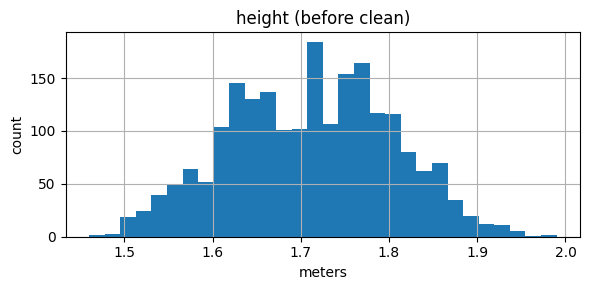

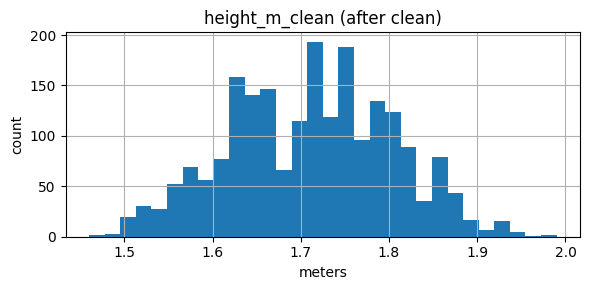

,height_raw,height_m_clean
498,1.696306,1.70
499,1.693124,1.69
500,1.632397,1.63
501,1.765643,1.77
502,1.853419,1.85
503,1.755600,1.76
504,1.640927,1.64
505,1.639191,1.64
506,1.780612,1.78
507,1.753702,1.75


In [5]:
# Step 3.2 — Clean `height` (เมตร) และสร้างคอลัมน์ใหม่ height_m_clean
# เก็บของดิบไว้ก่อนสำหรับเทียบ
if "height_raw" not in df.columns:
    df["height_raw"] = df["height"]

# แปลงเป็นตัวเลข (ค่าที่แปลงไม่ได้จะเป็น NaN)
h_num = pd.to_numeric(df["height"], errors="coerce")

# รายงานสถานะก่อนทำ
print("ก่อนทำความสะอาด (height — meters)")
print(" - จำนวนแถวทั้งหมด:", len(df))
print(" - จำนวนค่า missing:", h_num.isna().sum())
print(" - ค่าต่ำสุด/สูงสุด (ignore NaN):", float(np.nanmin(h_num)), "/", float(np.nanmax(h_num)))

# เติมค่าว่างด้วย median
h_med = float(np.nanmedian(h_num))
h_imp = h_num.fillna(h_med)

# กำหนดช่วงที่สมเหตุสมผลของความสูงมนุษย์ (เมตร)
LOW, HIGH = 1.20, 2.20

# นับจำนวนที่จะถูก clip ออกเพราะหลุดช่วง
n_low  = int((h_imp < LOW).sum())
n_high = int((h_imp > HIGH).sum())

# clip + ปัดทศนิยมเหลือ 2 ตำแหน่ง (เช่น 1.826298 -> 1.83)
h_clip = h_imp.clip(LOW, HIGH)
df["height_m_clean"] = h_clip.round(2)

print("\nหลังทำความสะอาด")
print(f" - ใช้ median ในการเติม: {h_med:.2f} m")
print(f" - จำนวนที่ต่ำกว่า {LOW} m (ถูก clip):", n_low)
print(f" - จำนวนที่สูงกว่า {HIGH} m (ถูก clip):", n_high)
print(df["height_m_clean"].describe())

# ฮิสโตแกรมก่อน–หลัง (อย่างละกราฟ)
plt.figure(figsize=(6,3))
h_num.dropna().astype(float).hist(bins=30)
plt.title("height (before clean)")
plt.xlabel("meters"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
df["height_m_clean"].hist(bins=30)
plt.title("height_m_clean (after clean)")
plt.xlabel("meters"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# ตัวอย่างแถวที่มีทศนิยมยาว ก่อน–หลัง
mask_dec = h_num.notna() & (np.abs(h_num - h_num.round(2)) > 1e-6)
df.loc[mask_dec, ["height_raw", "height_m_clean"]].head(10)

ก่อนทำความสะอาด (weight — kg)
 - จำนวนแถวทั้งหมด: 2111
 - จำนวนค่า missing: 6
 - ค่าต่ำสุด/สูงสุด (ignore NaN): 40.0 / 175.0

หลังทำความสะอาด
 - ใช้ median ในการเติม: 84.4 kg
 - จำนวนที่ต่ำกว่า 30.0 kg (ถูก clip): 0
 - จำนวนที่สูงกว่า 200.0 kg (ถูก clip): 0
count    2111.000000
mean       88.099195
std        26.161153
min        40.000000
25%        67.000000
50%        84.400000
75%       108.950000
max       175.000000
Name: weight_kg_clean, dtype: float64


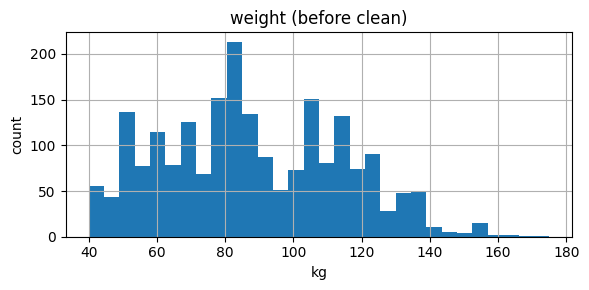

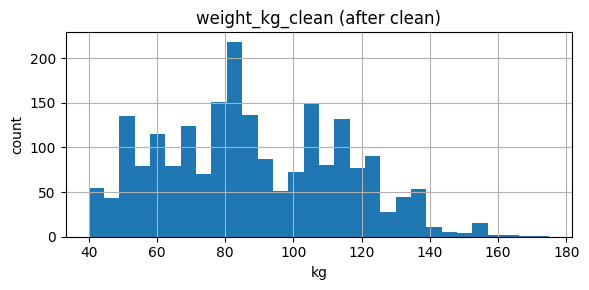

,weight_raw,weight_kg_clean
498,105.572712,105.6
499,128.673780,128.7
500,111.792630,111.8
501,138.796884,138.8
502,167.057269,167.1
503,134.034410,134.0
504,113.485516,113.5
505,106.826776,106.8
506,135.963349,136.0
507,55.927529,55.9


In [6]:
# Step 3.3 — Clean `weight` (kg) และสร้างคอลัมน์ใหม่ weight_kg_clean
# เก็บของดิบไว้ก่อน (เพื่อเทียบ)
if "weight_raw" not in df.columns:
    df["weight_raw"] = df["weight"]

# แปลงเป็นตัวเลข (ค่าที่แปลงไม่ได้ -> NaN)
w_num = pd.to_numeric(df["weight"], errors="coerce")

# รายงานสถานะก่อนทำ
print("ก่อนทำความสะอาด (weight — kg)")
print(" - จำนวนแถวทั้งหมด:", len(df))
print(" - จำนวนค่า missing:", w_num.isna().sum())
if (~w_num.isna()).any():
    print(" - ค่าต่ำสุด/สูงสุด (ignore NaN):", float(np.nanmin(w_num)), "/", float(np.nanmax(w_num)))

# เติมค่าว่างด้วย median
w_med = float(np.nanmedian(w_num))
w_imp = w_num.fillna(w_med)

# ช่วงที่เหมาะสมของน้ำหนักมนุษย์ (กก.)
LOW, HIGH = 30.0, 200.0

# นับที่จะถูก clip (ต่ำ/สูงเกิน)
n_low  = int((w_imp < LOW).sum())
n_high = int((w_imp > HIGH).sum())

# clip + ปัดทศนิยมให้เหลือ 1 ตำแหน่ง (เช่น 60.123176 -> 60.1)
w_clip = w_imp.clip(LOW, HIGH)
df["weight_kg_clean"] = w_clip.round(1)

print("\nหลังทำความสะอาด")
print(f" - ใช้ median ในการเติม: {w_med:.1f} kg")
print(f" - จำนวนที่ต่ำกว่า {LOW} kg (ถูก clip):", n_low)
print(f" - จำนวนที่สูงกว่า {HIGH} kg (ถูก clip):", n_high)
print(df["weight_kg_clean"].describe())

# ฮิสโตแกรมก่อน–หลัง (อย่างละกราฟ)
plt.figure(figsize=(6,3))
w_num.dropna().astype(float).hist(bins=30)
plt.title("weight (before clean)")
plt.xlabel("kg"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
df["weight_kg_clean"].hist(bins=30)
plt.title("weight_kg_clean (after clean)")
plt.xlabel("kg"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# ตัวอย่างค่าที่มีทศนิยมยาว ก่อน–หลัง
mask_dec = w_num.notna() & (np.abs(w_num - w_num.round(1)) > 1e-9)
df.loc[mask_dec, ["weight_raw", "weight_kg_clean"]].head(10)

สรุป BMI หลังคำนวณ:
count    2111.000000
mean       29.879986
std         7.910854
min        13.440000
25%        24.570000
50%        28.880000
75%        36.010000
max        50.570000
Name: BMI, dtype: float64


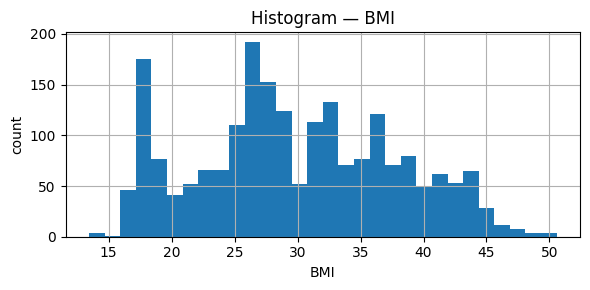

In [7]:
# Step 3.4 — สร้าง BMI จาก height_m_clean และ weight_kg_clean
h = df["height_m_clean"].replace(0, np.nan)
w = df["weight_kg_clean"]

bmi = w / (h**2)
# กันค่าแปลกมาก และปัดทศนิยม
clean_bmi = df["BMI"] = bmi.clip(10, 60).round(2) 

print("สรุป BMI หลังคำนวณ:")
print(df["BMI"].describe())

plt.figure(figsize=(6,3))
df["BMI"].dropna().hist(bins=30)
plt.title("Histogram — BMI")
plt.xlabel("BMI"); plt.ylabel("count")
plt.tight_layout(); plt.show()

In [8]:
# Step 3.5 - Clean Gender and Normalize 
from IPython.display import display
# ================ check missing value ============
g_raw = df["gender"]
is_missing = g_raw.isna() | (g_raw.astype(str).str.strip() == "")

total = len(df)
n_missing = int(is_missing.sum())
pct_missing = round(n_missing / total * 100, 2)


summary = pd.DataFrame({
    "metric": ["total_rows", "missing_rows", "missing_percent"],
    "value": [total, n_missing, pct_missing]
})
display("Step G-1 — Missing report for `gender`", summary)

# ================ check Fomat   ============
# เก็บของเดิมไว้ตรวจย้อนหลัง
if "gender_orig" not in df.columns:
    df["gender_orig"] = df["gender"]

# 1) ทำความสะอาดข้อความเบื้องต้น
g_norm = df["gender"].astype(str).str.strip().str.lower()

# 2) ตรวจว่ามีค่าที่ไม่ใช่ male/female หรือไม่
allowed = {"male", "female"}
unexpected_mask = ~g_norm.isin(allowed)

print(f"แถวทั้งหมด: {len(df)}")
print(f"จำนวนที่ไม่ใช่ male/female: {unexpected_mask.sum()}")

# 4) ถ้าไม่มีค่าประหลาด → สร้างคอลัมน์ที่บังคับฟอร์แมตเรียบร้อย
mapping = {"male": "Male", "female": "Female"}
df["gender_clean"] = g_norm.map(mapping)

# ยืนยันผล
print("\nผ่านการตรวจ: gender มีเฉพาะ Male/Female เท่านั้น")
print(df["gender_clean"].value_counts())


'Step G-1 — Missing report for `gender`'

,metric,value
0,total_rows,2111.0
1,missing_rows,0.0
2,missing_percent,0.0


แถวทั้งหมด: 2111
จำนวนที่ไม่ใช่ male/female: 0

ผ่านการตรวจ: gender มีเฉพาะ Male/Female เท่านั้น
gender_clean
Male      1068
Female    1043
Name: count, dtype: int64


In [9]:
# Step 3.6 - Clean overweight_family check missing + enforce format (0/1 integers only)

_overweight_family_raw = df["overweight_family"]

# ================ check missing value ============
is_missing = _overweight_family_raw.isna() | (_overweight_family_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

# ================ check format ============

num = pd.to_numeric(_overweight_family_raw, errors="coerce")  # แปลงเป็นตัวเลขเพื่อเช็ค
ok_mask = num.isin([0, 1])
bad_mask = (~num.isna()) & (~ok_mask)

unique_numeric = sorted(set(num.dropna().tolist()))
print(f"[OF-2] ค่าตัวเลขที่พบ: {unique_numeric}")
# `_overweight_family_raw` is a Series, so call value_counts() directly on it
display(_overweight_family_raw.value_counts())

# ============================
    # ไม่มี Missing และค่าแปลก สามารถใช้ข้อมูลเดิมได้เลย

[OF-1] Missing: 0 / 2111 rows (0.00%)
[OF-2] ค่าตัวเลขที่พบ: [0, 1]


overweight_family
1    1726
0     385
Name: count, dtype: int64

In [10]:
# Step 3.6 - Clean consum_cf check missing + enforce format (0/1 integers only)
consum_cf_raw = df["consum_cf"]
# ================ check missing value ============
is_missing = consum_cf_raw.isna() | (consum_cf_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

# ================ check format ============

num = pd.to_numeric(consum_cf_raw, errors="coerce")  # แปลงเป็นตัวเลขเพื่อเช็ค
ok_mask = num.isin([0, 1])
bad_mask = (~num.isna()) & (~ok_mask)

unique_numeric = sorted(set(num.dropna().tolist()))
print(f"[OF-2] ค่าตัวเลขที่พบ: {unique_numeric}")
# `consum_cf_raw` is a Series, so call value_counts() directly on it
display(consum_cf_raw.value_counts())

# ============================
    # ไม่มี Missing และค่าแปลก สามารถใช้ข้อมูลเดิมได้เลย

[OF-1] Missing: 0 / 2111 rows (0.00%)
[OF-2] ค่าตัวเลขที่พบ: [0, 1]


consum_cf
1    1866
0     245
Name: count, dtype: int64

In [11]:
# Step 3.7 - Clean consum_vf check missing + enforce format rank 1-3 integers only

consum_vf_raw = df["consum_vf"]

# ================ check missing value ============

is_missing = consum_vf_raw.isna() | (consum_vf_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

# ================ check format ============

num = pd.to_numeric(consum_vf_raw, errors="coerce")  # แปลงเป็นตัวเลขเพื่อเช็ค
ok_mask = num.isin([1, 2, 3])
bad_mask = (~num.isna()) & (~ok_mask)

unique_numeric = sorted(set(num.dropna().tolist()))
print(f"[OF-2] ค่าตัวเลขที่พบ: {unique_numeric}")
# `consum_vf_raw` is a Series, so call value_counts() directly on it

# ================ convert to int ============

consum_vf_clean = df["consum_vf_clean"] = consum_vf_raw.astype(int)
print("หลังทำความสะอาด")
display(df["consum_vf_clean"].value_counts())



[OF-1] Missing: 0 / 2111 rows (0.00%)
[OF-2] ค่าตัวเลขที่พบ: [1.0, 1.003566, 1.005578, 1.00876, 1.031149, 1.036159, 1.036414, 1.052699, 1.053534, 1.063449, 1.064162, 1.067909, 1.078529, 1.081585, 1.0816, 1.096455, 1.108663, 1.116068, 1.118436, 1.122127, 1.123672, 1.123939, 1.133844, 1.140615, 1.142468, 1.164062, 1.168856, 1.188089, 1.202075, 1.203754, 1.204855, 1.206276, 1.212908, 1.21498, 1.220024, 1.261288, 1.263216, 1.264234, 1.270448, 1.276858, 1.27785, 1.289315, 1.303878, 1.306844, 1.31415, 1.317729, 1.321028, 1.3307, 1.34138, 1.344854, 1.362441, 1.368978, 1.369529, 1.387489, 1.392665, 1.397468, 1.412566, 1.428289, 1.431346, 1.443674, 1.450218, 1.451337, 1.452524, 1.455602, 1.457758, 1.469384, 1.475906, 1.482722, 1.4925, 1.492834, 1.517912, 1.518966, 1.521604, 1.522001, 1.524428, 1.528331, 1.537505, 1.557287, 1.562804, 1.567101, 1.570089, 1.572036, 1.57223, 1.585183, 1.588114, 1.588782, 1.592183, 1.595746, 1.601236, 1.617093, 1.620845, 1.624366, 1.626369, 1.631144, 1.642241, 1.649

consum_vf_clean
2    1257
3     652
1     202
Name: count, dtype: int64

In [12]:
# Step 3.8 - Clean comsum_daily check missing + enforce format rank 1-4 integers only

consum_daily_raw = df["comsum_daily"]

# ================ check missing value ============

is_missing = consum_daily_raw.isna() | (consum_daily_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

# ================ check format ============
num = pd.to_numeric(consum_daily_raw, errors="coerce")  # แปลงเป็นตัวเลขเพื่อเช็ค
ok_mask = num.isin([1, 2, 3, 4])
bad_mask = (~num.isna()) & (~ok_mask)

unique_numeric = sorted(set(num.dropna().tolist()))
print(f"[OF-2] ค่าตัวเลขที่พบ: {unique_numeric}")
# `consum_daily_raw` is a Series, so call value_counts() directly on it

# ================ convert to int ============

consum_daily_clean = df["consum_daily_clean"] = consum_daily_raw.astype(int)
print("\nหลังทำความสะอาด")
display(df["consum_daily_clean"].value_counts())




[OF-1] Missing: 0 / 2111 rows (0.00%)
[OF-2] ค่าตัวเลขที่พบ: [1.0, 1.000283, 1.000414, 1.00061, 1.001383, 1.001542, 1.001633, 1.005391, 1.009426, 1.010319, 1.014916, 1.015488, 1.02075, 1.030416, 1.032887, 1.044628, 1.046144, 1.047197, 1.049534, 1.058123, 1.060796, 1.068196, 1.068443, 1.073421, 1.075553, 1.077331, 1.07976, 1.081805, 1.082304, 1.08687, 1.089048, 1.095223, 1.097312, 1.09749, 1.099151, 1.101404, 1.104642, 1.10548, 1.105617, 1.109956, 1.114564, 1.116401, 1.120102, 1.124977, 1.130751, 1.131695, 1.134042, 1.134321, 1.135278, 1.13715, 1.139317, 1.146052, 1.146794, 1.152521, 1.154318, 1.163666, 1.169173, 1.171027, 1.178708, 1.193589, 1.193729, 1.194815, 1.198643, 1.202179, 1.211606, 1.213431, 1.226342, 1.231915, 1.237454, 1.240046, 1.240424, 1.24884, 1.250548, 1.25535, 1.259628, 1.259803, 1.262831, 1.265463, 1.271624, 1.273128, 1.2919, 1.293342, 1.296156, 1.311797, 1.313403, 1.317884, 1.320768, 1.322087, 1.326982, 1.338033, 1.340361, 1.343117, 1.346987, 1.355354, 1.355752, 1.37

consum_daily_clean
3    1362
1     395
2     285
4      69
Name: count, dtype: int64

In [13]:
# Step 3.9 - Clean consum_other check missing + enforce format (Sometimes, Frequency, Always, no)
consum_other_raw = df["consum_other"]
# ================ check missing value ============

is_missing = consum_other_raw.isna() | (consum_other_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(consum_other_raw.value_counts())

[OF-1] Missing: 0 / 2111 rows (0.00%)


consum_other
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

In [14]:
# Step 3.10 - Clean smoking check missing + enforce format ( yes / no )
smoking_raw = df["smoking"]

# ================ check missing value ============
is_missing = smoking_raw.isna() | (smoking_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(smoking_raw.value_counts())



[OF-1] Missing: 0 / 2111 rows (0.00%)


smoking
no     2067
yes      44
Name: count, dtype: int64

In [15]:
# Step 3.10 - Clean consum_water check missing + enforce format (1-3 integers only)
consum_water_raw = df["consum_water"]
# ================ check missing value ============

is_missing = consum_water_raw.isna() | (consum_water_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(consum_water_raw.value_counts())

# ================= Convert to int format ============

consum_water_clean = df["consum_water"] = consum_water_raw.astype(int)
print("\nหลังทำความสะอาด")
display(consum_water_clean.value_counts())


[OF-1] Missing: 0 / 2111 rows (0.00%)


consum_water
2.000000    448
1.000000    211
3.000000    162
1.636326      3
2.825629      3
           ... 
2.722276      1
2.634342      1
2.619390      1
2.786780      1
2.863513      1
Name: count, Length: 1268, dtype: int64


หลังทำความสะอาด


consum_water
2    1180
1     769
3     162
Name: count, dtype: int64

In [16]:
# Step 3.11 - Clean cal_monitoring check missing + enforce format (yes / no)
cal_monitoring_raw = df["cal_monitoring"]

# ================ check missing value ============

is_missing = cal_monitoring_raw.isna() | (cal_monitoring_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())   
total = len(df)
display(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(cal_monitoring_raw.value_counts())

'[OF-1] Missing: 0 / 2111 rows (0.00%)'

cal_monitoring
no     2015
yes      96
Name: count, dtype: int64

In [17]:
# Step 3.12 - Clean physical_activity check missing + enforce format (1-3 integers only)
physical_activity_raw = df["phyical_activity"]

# ================ check missing value ============

is_missing = physical_activity_raw.isna() | (physical_activity_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())   
total = len(df)
display(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")


ser = pd.to_numeric(df["phyical_activity"], errors="coerce")

mode_vals = ser.mode(dropna=True)
impute_val = int(round(mode_vals.iloc[0])) if len(mode_vals) else 2
print(f"[PA] ใช้ค่าเติม (impute): {impute_val}")

ser_round = np.rint(ser).astype(float)           # ปัดค่าที่ไม่ใช่จำนวนเต็ม
ser_round[is_missing] = impute_val             # เติม missing
clean = np.clip(ser_round, 1, 3).astype(int)


# บังคับช่วงและชนิดข้อมูล
df["phyical_activity" + "_clean"] = clean
df["phyical_activity" + "_imputed_flag"] = is_missing.astype(int)  # 1=เคยเติม, 0=ไม่เติม

# 6) รายงานผล
print("\n[PA] Value counts หลังทำความสะอาด (ควรเห็นแค่ 1,2,3):")
display(df["phyical_activity" + "_clean"].value_counts().sort_index())
print("\n[PA] จำนวนแถวที่ถูกเติมค่า (imputed_flag=1):", int(df["phyical_activity" + "_imputed_flag"].sum()))
print("[PA] ตัวอย่าง index ที่ถูกเติม:", df.index[is_missing].tolist()[:10])

physical_activity_clean = df["phyical_activity" + "_clean"]


'[OF-1] Missing: 5 / 2111 rows (0.24%)'

[PA] ใช้ค่าเติม (impute): 0

[PA] Value counts หลังทำความสะอาด (ควรเห็นแค่ 1,2,3):


phyical_activity_clean
1    1497
2     495
3     119
Name: count, dtype: int64


[PA] จำนวนแถวที่ถูกเติมค่า (imputed_flag=1): 5
[PA] ตัวอย่าง index ที่ถูกเติม: [10, 68, 82, 120, 125]


In [18]:
# Step 3.13 - Clean device_usage check missing + enforce format (0-2 integers only)

device_usage_raw = df["device_usage"]

# ================ check missing value ============

is_missing = device_usage_raw.isna() | (device_usage_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

# ================ Conform format ============

device_usage_clean = df["device_usage"] = device_usage_raw.astype(int)
print("\nหลังทำความสะอาด")
display(device_usage_clean.value_counts())

[OF-1] Missing: 0 / 2111 rows (0.00%)

หลังทำความสะอาด


device_usage
0    1415
1     587
2     109
Name: count, dtype: int64

In [19]:
# step 3.14 Clean consum_alchohol check missing 
  
consum_alchohol_raw = df["consum_alchohol"]

# ================ check missing value ============

is_missing = consum_alchohol_raw.isna() | (consum_alchohol_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(consum_alchohol_raw.value_counts())



[OF-1] Missing: 0 / 2111 rows (0.00%)


consum_alchohol
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

In [20]:
# Step 3.15 clean other_disease check missing 
other_disease_raw = df["transportation"]

# ================ check missing value ============

is_missing = other_disease_raw.isna() | (other_disease_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(other_disease_raw.value_counts())


[OF-1] Missing: 0 / 2111 rows (0.00%)


transportation
pt    1580
c      457
w       56
mb      11
b        7
Name: count, dtype: int64

In [23]:
# Step 3.15 clean Obesity check missing 

Obesity_raw = df["Obesity"]

# ================ check missing value ============

is_missing = Obesity_raw.isna() | (Obesity_raw.astype(str).str.strip() == "")
n_missing = int(is_missing.sum())
total = len(df)
print(f"[OF-1] Missing: {n_missing} / {total} rows ({n_missing/total*100:.2f}%)")

display(Obesity_raw.value_counts())

[OF-1] Missing: 0 / 2111 rows (0.00%)


Obesity
4    351
6    324
5    297
2    290
3    290
1    287
0    272
Name: count, dtype: int64

In [ ]:
# สรุปข้อมูลที่ทำความสะอาดแล้ว
display(df["gender_clean"].value_counts(), df["BMI"].value_counts(), df["height_m_clean"].value_counts(), 
        df["weight_kg_clean"].value_counts(), df["overweight_family"].value_counts(), df["consum_cf"].value_counts(), 
        df["consum_vf_clean"].value_counts(), df["consum_daily_clean"].value_counts(), df["consum_other"].value_counts(), 
        df["smoking"].value_counts(), df["consum_water"].value_counts(), df["cal_monitoring"].value_counts(), 
        df["phyical_activity" + "_clean"].value_counts(), device_usage_clean.value_counts(),consum_alchohol_raw.value_counts(),
        other_disease_raw.value_counts(),Obesity_raw.value_counts())

gender_clean
Male      1068
Female    1043
Name: count, dtype: int64

BMI
29.76    11
26.72    10
27.10    10
18.80    10
27.02     9
         ..
43.83     1
43.96     1
44.47     1
44.54     1
45.86     1
Name: count, Length: 1247, dtype: int64

height_m_clean
1.71    125
1.76    122
1.63     96
1.77     96
1.66     88
1.61     77
1.73     76
1.64     75
1.78     71
1.72     68
1.65     66
1.75     66
1.68     66
1.80     65
1.79     64
1.62     62
1.69     61
1.81     59
1.67     58
1.70     54
1.83     50
1.74     43
1.85     40
1.57     39
1.86     39
1.82     39
1.84     35
1.56     32
1.58     30
1.60     29
1.59     27
1.54     27
1.88     22
1.87     21
1.55     20
1.53     19
1.51     17
1.92     13
1.52     11
1.89     10
1.90      7
1.91      7
1.94      4
1.49      3
1.93      3
1.50      3
1.99      2
1.46      1
1.47      1
1.96      1
1.95      1
Name: count, dtype: int64

weight_kg_clean
82.0     47
52.0     32
61.0     27
77.0     27
71.0     26
         ..
130.1     1
128.8     1
130.7     1
114.8     1
157.2     1
Name: count, Length: 702, dtype: int64

overweight_family
1    1726
0     385
Name: count, dtype: int64

consum_cf
1    1866
0     245
Name: count, dtype: int64

consum_vf_clean
2    1257
3     652
1     202
Name: count, dtype: int64

consum_daily_clean
3    1362
1     395
2     285
4      69
Name: count, dtype: int64

consum_other
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

smoking
no     2067
yes      44
Name: count, dtype: int64

consum_water
2    1180
1     769
3     162
Name: count, dtype: int64

cal_monitoring
no     2015
yes      96
Name: count, dtype: int64

phyical_activity_clean
1    1497
2     495
3     119
Name: count, dtype: int64

device_usage
0    1415
1     587
2     109
Name: count, dtype: int64

consum_alchohol
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

transportation
pt    1580
c      457
w       56
mb      11
b        7
Name: count, dtype: int64

Obesity
4    351
6    324
5    297
2    290
3    290
1    287
0    272
Name: count, dtype: int64

In [ ]:
# Step 4: Export ข้อมูลที่ทำความสะอาดแล้ว
out = df[["gender_clean", "age_clean","BMI", "height_m_clean", "weight_kg_clean", "overweight_family", "consum_cf", "consum_vf_clean"
          , "consum_daily_clean", "consum_other", "smoking", "consum_water", "cal_monitoring", "phyical_activity" + "_clean", 
          "device_usage", "consum_alchohol", "transportation", "Obesity"]].copy()

out.rename(columns={"gender_clean": "gender"}, inplace=True)
out.rename(columns={"age": "age"}, inplace=True)
out.rename(columns={"BMI": "bmi"}, inplace=True)
out.rename(columns={"height_m_clean": "height_m"}, inplace=True)
out.rename(columns={"weight_kg_clean": "weight_kg"}, inplace=True)
out.rename(columns={"overweight_family": "overweight_family"}, inplace=True)
out.rename(columns={"consum_cf": "consum_cf"}, inplace=True)
out.rename(columns={"consum_vf_clean": "consum_vf"}, inplace=True)
out.rename(columns={"consum_daily_clean": "consum_daily"}, inplace=True)
out.rename(columns={"consum_other": "consum_other"}, inplace=True)
out.rename(columns={"smoking": "smoking"}, inplace=True)
out.rename(columns={"consum_water": "consum_water"}, inplace=True)
out.rename(columns={"cal_monitoring": "cal_monitoring"}, inplace=True)
out.rename(columns={"phyical_activity" + "_clean": "phyical_activity"}, inplace=True)
out.rename(columns={"device_usage": "device_usage"}, inplace=True)
out.rename(columns={"consum_alchohol": "consum_alchohol"}, inplace=True)
out.rename(columns={"transportation": "transportation"}, inplace=True)
out.rename(columns={"Obesity": "Obesity"}, inplace=True)

out.to_csv("MOBS_02S_Clean.csv", index=False, encoding="utf-8-sig")